In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b876f27d4f579a083df9d7cfab9bb737698206ca8eba16271af5dfe804b30801
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3dee231f42e02554694ee8df800a614d4cec73f44faae45dfa7cc04261dfeee6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 29.71 MiB/s, done.
Updating files: 100% (12939/12939), done.


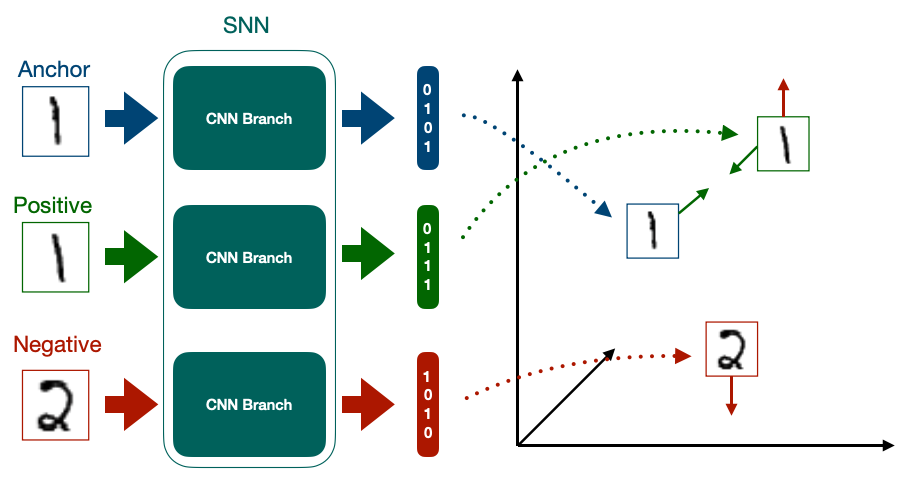

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15
DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df. head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

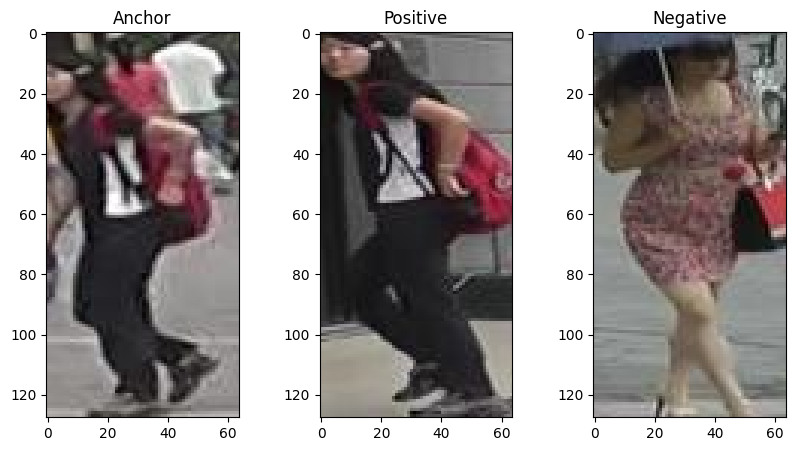

In [ ]:
f, (axl, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))
axl. set_title("Anchor")
axl. imshow(A_img)
ax2. set_title("Positive")
ax2. imshow(P_img)
ax3. set_title ("Negative")
ax3. imshow(N_img )

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len (self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io. imread (DATA_DIR + row. Anchor)
    P_img = io. imread (DATA_DIR + row. Positive)
    N_img = io. imread (DATA_DIR + row. Negative)

    A_img = torch.from_numpy (A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute (2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len (validset)}")

Size of trainset : 3200
Size of validset : 800


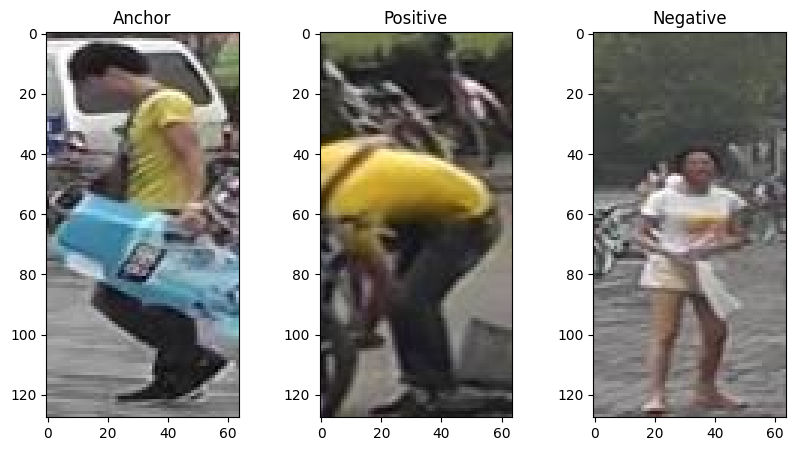

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn. Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)
  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [ ]:
model = APN_Model()
model. to (DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader) :
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion (A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss. backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
  model.eval() # OFF Dropout
  total_loss = 0.0
  with torch.no_grad():
    for A, P, N in tqdm(dataloader) :
      A, P, N = A. to(DEVICE), P. to(DEVICE), N. to (DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion (A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim. Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf
for i in range (EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn (model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch. save(model.state_dict(), 'best_ model.pt' )
    best_valid_loss = valid_loss
    print ("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.6202655616402626 valid_loss : 0.5900719046592713


100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.2969724728167057 valid_loss : 0.21793490827083586


100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


EPOCHS : 3 train_loss : 0.14192307323217393 valid_loss : 0.3359761774539948


100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


EPOCHS : 4 train_loss : 0.15504712969064713 valid_loss : 0.3047336584329605


100%|██████████| 25/25 [00:02<00:00,  8.54it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 5 train_loss : 0.12686863228678702 valid_loss : 0.19510978758335112


100%|██████████| 25/25 [00:03<00:00,  8.29it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 6 train_loss : 0.08642958000302314 valid_loss : 0.17198307424783707


100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.07415675267577171 valid_loss : 0.166801860332489


100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


EPOCHS : 8 train_loss : 0.046675421372056006 valid_loss : 0.20334420263767242


100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


EPOCHS : 9 train_loss : 0.04581776320934296 valid_loss : 0.24285390853881836


100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


EPOCHS : 10 train_loss : 0.05928096748888492 valid_loss : 0.2121301406621933


100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


EPOCHS : 11 train_loss : 0.05073571741580963 valid_loss : 0.17524347543716431


100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 12 train_loss : 0.037927059829235076 valid_loss : 0.13258701503276826


100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


EPOCHS : 13 train_loss : 0.03296933598816395 valid_loss : 0.21843491971492768


100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


EPOCHS : 14 train_loss : 0.03417290896177292 valid_loss : 0.21165184557437897


100%|██████████| 25/25 [00:02<00:00,  9.72it/s]

EPOCHS : 15 train_loss : 0.05757022351026535 valid_loss : 0.25100418835878374


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np. array (anc_img_names)
  encodings = []
  model.eval ()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr) :
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A. to (DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy ())
    encodings = np.array (encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd. concat([anc_img_names, encodings], axis = 1)
  return df_enc

In [ ]:
model.load_state_dict(torch.load('/content/best_ model.pt'))
df_enc = get_encoding_csv(model, df[ 'Anchor'])

100%|██████████| 4000/4000 [00:50<00:00, 79.81it/s]


In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc. head ()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.160413,0.501370,0.456830,-0.147206,-0.167228,-0.062053,0.567584,0.889975,-0.332029,...,0.080462,-0.037155,-1.315195,-0.770855,0.678402,0.101987,0.345860,0.622612,0.726205,0.155384
1,1420_c3s3_061978_03.jpg,-0.565996,0.435322,0.450055,-0.037972,-0.537295,-0.534968,1.029455,0.729299,-0.280686,...,0.475900,0.127635,-0.420700,-1.150158,0.430732,0.277554,-0.197406,0.128317,0.150903,0.588546
2,1420_c5s3_062565_05.jpg,0.028845,0.442837,0.432841,0.092721,-0.155136,0.002505,0.704351,0.659877,-0.225255,...,0.144018,0.122196,-0.841960,-0.819971,0.536242,0.143404,0.216723,0.393153,0.541355,0.188899
3,1420_c6s3_085592_04.jpg,-0.200797,0.497993,0.409177,-0.187956,-0.212770,-0.197642,0.823662,0.746019,-0.566712,...,0.012440,0.242444,-0.893053,-1.057077,0.385196,0.109871,0.176769,0.164024,0.710063,0.182853
4,0663_c5s3_085987_03.jpg,-1.055459,-0.415673,-0.289618,0.285154,0.072611,-0.350420,-0.001827,-0.004442,-0.378766,...,-0.130050,0.147318,0.733176,0.737265,-0.500299,-0.418016,-0.719066,0.296427,-0.624529,-0.738259


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np. sqrt(np.dot (img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T) )
  return dist

In [ ]:
idx = 0

img_name = df_enc[ 'Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval ()

with torch.no_grad():

  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy ()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc[ 'Anchor']

In [ ]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append (distance, dist)



In [ ]:
closeset_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


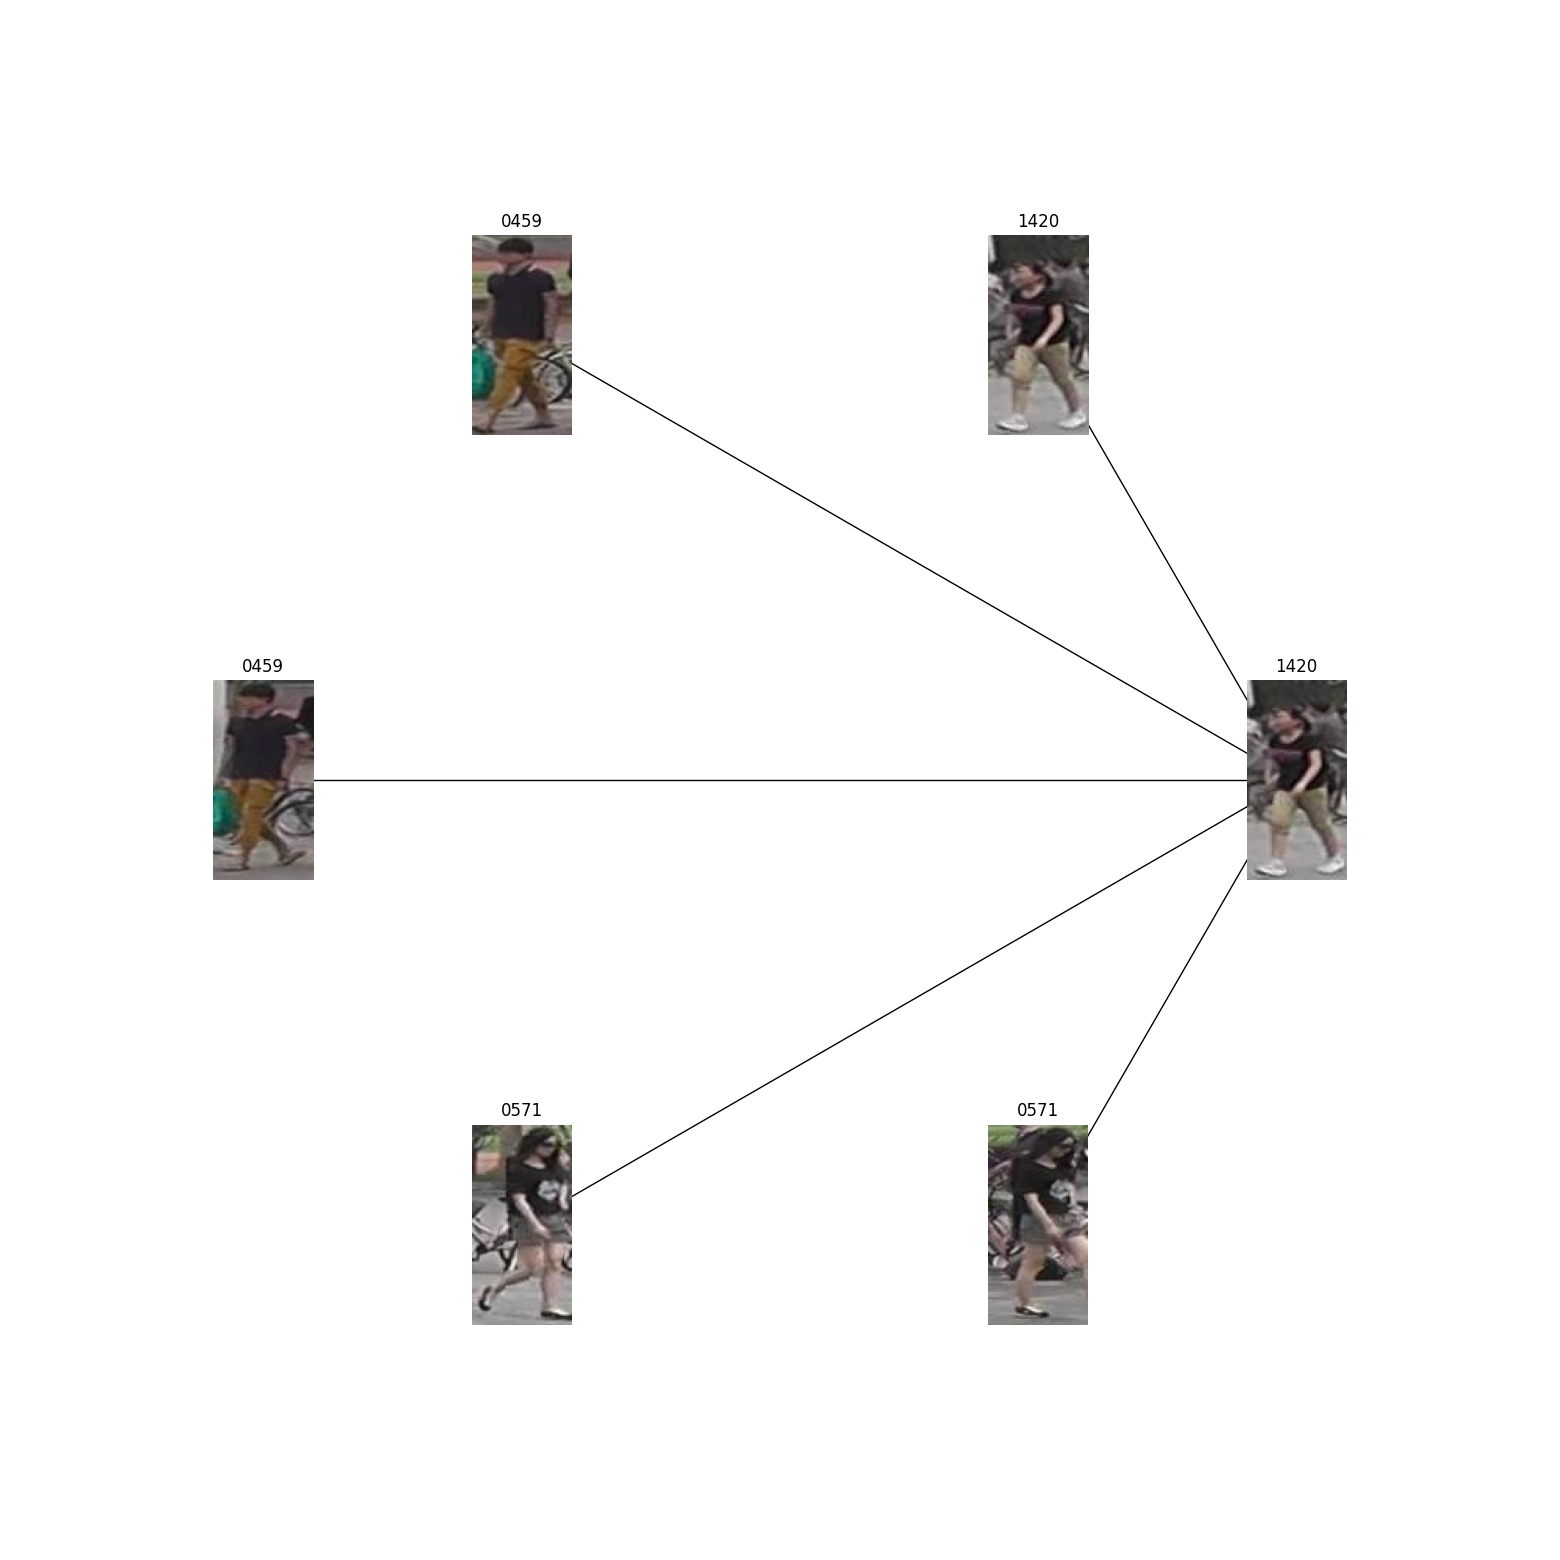

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closeset_idx, distance, no_of_closest = 5);